# <center> TP 3.2 - Dynamique de la prévisibilité dans le GCMG  <center/>
# <center> & TP 3.3 - Gain et impact de marché <center/>
---
---
> Buts des TPs : 
- 3.2 : Implémenter le jeu de la minorité grand canonique, étudier le rôle des paramètres sur la dynamique, ainsi que la synamique de la prévisibilité.
- 3.3 : Etudier le gain de catégories d'investisseurs, la différence entre gain espéré et réalisé, ainsi que l'impact d'un seul investisseur sur la dynamique de marché.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
plt.style.use("ggplot")

---
# <center> TP 3.2 - Dynamique de la prévisibilité dans le GCMG <center/>

# Implémentation

## 1) On programme le modèle

- Nous avons aussi inséré les éléments de code requis pour le TP 3.3

- Paramètres par défaut : 
  - $1000$ itérations
  - $N_s = 1000$ spéculateurs
  - $P = 20$ états de marché
  - $N_p = 20$ produteurs tel que $np = Np/P = 1$, comme précisé.
  - $epsilon = 0.01$ limite de profit pour qu'un joueur entre dans le jeu (ou coût de transaction)

In [ ]:
class GC_MinorityGame(object):
  """ Classe représentant le jeu de la minorité grand canonique : chaque agent a une stratégie
      et peut ne pas jouer"""
  def __init__(self, nb_it=1000, Ns=1000, P=20, Np=20, epsilon=0.01, fix_seed=False, compute_prev = False, it_a_best=0, compute_gains=False, wait_stationnarity = False):
    self.nb_it = nb_it
    self.Ns = Ns
    self.P = P
    self.Np = Np
    self.eps = epsilon
    self.fix_seed = fix_seed
    if epsilon != 0: self.station_point = int(2*P/epsilon)
    self.it_a_best = it_a_best # Arrivé de l'agent best
    self.compute_gains = compute_gains
    self.wait_stationnarity = wait_stationnarity

    if self.fix_seed: np.random.seed(100)
    # Notre matrice a aléatoire : agent i en lignes et états de marché mu en colonne
    self.a = np.random.randint(-1,1, size=(self.Ns,self.P)); self.a[self.a==0] = 1
    
    if self.fix_seed: np.random.seed(100)
    # Cas producteurs, leur contribution
    self.omegap = np.random.normal(0,np.sqrt(self.Np),size=self.P)

    if not self.wait_stationnarity:
      self.station_point = 0

    # Cas total
    self.A_tot = np.zeros(self.nb_it + self.station_point)
    # Matrice de A_tot conditionnelle aux mus
    self.A_cond_tot = np.zeros((self.nb_it + self.station_point, self.P))

    # Spéculateurs
    # On initialise notre A_t pour spéculateurs
    self.A_spec = np.zeros(self.nb_it + self.station_point)
    # Gain et gain conditionnel
    self.G_spec = np.zeros(self.nb_it + self.station_point)
    self.G_cond_spec = np.zeros((self.nb_it + self.station_point, self.P))

    # Producteurs
    # Gain et gain conditionnel
    self.G_prod = np.zeros(self.nb_it + self.station_point)
    self.G_cond_prod = np.zeros((self.nb_it + self.station_point, self.P))
    
    # Et la matrice de A_t conditionnelle aux mus
    self.A_cond_tot = np.zeros((self.nb_it + self.station_point, self.P))

     # On initialise le U
    self.U = np.zeros(self.Ns)

    # Matrice d'apparition des mus (utile pour les tranches)
    self.mus_tot = np.zeros((self.nb_it + self.station_point, self.P))   

    # Nombre d'agents actifs dans le jeu
    self.nb_ag_actifs = np.zeros(self.nb_it + self.station_point)

    # Agent best (reste à 0 si it_a_best = 0 : agent best pas pris en compte)
    self.a_best = np.zeros(self.P) # Sa stratégie optimale
    self.A_cond_with_a_best = np.zeros((self.nb_it + self.station_point - self.it_a_best, self.P)) # sera rempli à partir de l'arrivée de agent best
    self.mus_count_a_best = np.zeros(self.P) # sera rempli à partir de l'arrivée de agent best

  def run(self):
    """ Fonction permettant de lancer le jeu de la minorité en fonction du nombre de paramètres."""


    for t in range(int(self.nb_it + self.station_point)):

      # On calcule n qui permet de savoir si les agent jouent ou pas
      n = (self.U>0)

      # Nombre d'agents actifs sur l'itération
      self.nb_ag_actifs[t] = sum(n) + self.Np 

      # Le mu_t qui est aléatoire à chaque itération
      mu_t = np.random.randint(0,self.P)
      self.mus_tot[t, mu_t] += 1

      # Contribution spéculateurs, avec ou sans l'agent best (sa contribution est de 0 avant son arrivée)
      self.A_spec[t] = n@self.a[:,mu_t] + self.a_best[mu_t]

      # Contribution totale
      self.A_tot[t] = self.omegap[mu_t] + self.A_spec[t]

      # Gains spéculateurs et producteurs
      self.G_spec[t] = - self.A_spec[t]*self.A_tot[t]
      self.G_prod[t] = - self.omegap[mu_t]*self.A_tot[t]

      # On met à jour les variables conditionnelles
      self.A_cond_tot[t, mu_t] = self.A_tot[t] # Pour la prévisibilité
      self.G_cond_spec[t,mu_t] = self.G_spec[t]
      self.G_cond_prod[t,mu_t] = self.G_prod[t]

      # Mise à jour du U : score
      self.U -= self.a[:,mu_t]*self.A_tot[t] - self.eps 

      # -------- On traite le cas de l'agent best -----------------------
      if t >= self.it_a_best and self.it_a_best != 0:
        if t == self.it_a_best:
          # On calcule la moyenne conditionnelle totale pour déterminer la stratégie optimale de l'agent best
          avg_A_cond_tot = np.sum(self.A_cond_tot, axis=0)/np.sum(self.mus_tot,axis=0)
          # Sa stratégie optimale
          self.a_best = - np.sign(avg_A_cond_tot)
          # On calule son gain naïf
          self.naivegain_best = (np.sum(np.abs(avg_A_cond_tot)))/self.P
          # Conditionnement des contributions totales depuis l'arrivée de a_best
          self.A_cond_with_a_best[t-self.it_a_best, mu_t] = self.A_tot[t] + self.a_best[mu_t]
          self.mus_count_a_best[mu_t] += 1
        else:
          # Conditionnement des contributions totales depuis l'arrivée de a_best
          self.A_cond_with_a_best[t-self.it_a_best, mu_t] = self.A_tot[t] + self.a_best[mu_t]
          self.mus_count_a_best[mu_t] += 1

    if self.compute_gains:
      # Average payoff des gains pour les spéculateurs et pour les producteurs pour tous les états de marchés
      self.avg_payoff_spec = (np.sum(np.sum(self.G_cond_spec, axis=0)/np.sum(self.mus_tot,axis=0)))/self.P
      self.avg_payoff_prod = (np.sum(np.sum(self.G_cond_prod, axis=0)/np.sum(self.mus_tot,axis=0)))/self.P

      # Moyenne conditionelle de la contribution totale
      self.avg_A_cond_tot = np.sum(self.A_cond_tot, axis=0)/np.sum(self.mus_tot,axis=0)

    # Gain réel de l'agent best
    if self.it_a_best != 0:
      self.realgain_best = -(np.sum(self.a_best*(np.sum(self.A_cond_with_a_best, axis=0)/self.mus_count_a_best)))/self.P


  def compute_sig_H(self, after_station = False):
    """ Fonction permettant de calculer sigma2 et la prévisibilité H"""
    if all(self.A_tot == 0):
      print("Veuillez d'abord lancer le jeu.")
      return

    # Apres la stationnarité on ne calcule pas par tranches
    if after_station:
      A_cond_tot_after = np.sum(self.A_cond_tot[self.station_point:, :], axis=0)
      mus_tot_temp = np.sum(self.mus_tot[self.station_point:, :], axis=0)

      # self.sigma2 = np.sum(A_cond_tot_after**2)/(self.Ns)
      self.sigma2 = np.sum(A_cond_tot_after**2)/self.Ns
      # self.H = np.sum((A_cond_tot_after/mus_tot_temp)**2)/(self.P*self.Ns)
      self.H = np.sum((A_cond_tot_after/mus_tot_temp)**2)/(self.P*self.Ns)

    else:
      # On calcule le nombre de tranches  
      nb_split = int(len(self.A_tot)/(10*self.P))
      self.sigma2 = np.zeros(nb_split)
      self.H = np.zeros(nb_split)
      for i in range(nb_split):
        # On calcule sigma^2
        A2 = self.A_tot[i*int(10*self.P):(i+1)*int(10*self.P)]**2
        self.sigma2[i] = np.average(A2)/self.Ns
        # On calcule la prévisibilité H
        mus_temp = np.sum(self.mus_tot[i*int(10*self.P):(i+1)*int(10*self.P), :], axis=0)
        A_cond_tot_temp = np.sum(self.A_cond_tot[i*int(10*self.P):(i+1)*int(10*self.P), :], axis=0)
        self.H[i] = np.sum((A_cond_tot_temp / mus_temp)**2)/(self.P*self.Ns)
    

## 2) Vérifier que les fluctuations explosent

- Nous allons voir si les fluctuations explosent si le nombre de spéculateurs est suffisamment grand pour $t$ suffisamment grand.

- Nous tracons l'intervalle de fluctuations $A(t) \in [-50,50]$ pour tous nos graphiques afin de pouvoir comparer visuellement l'intensité des fluctuations.

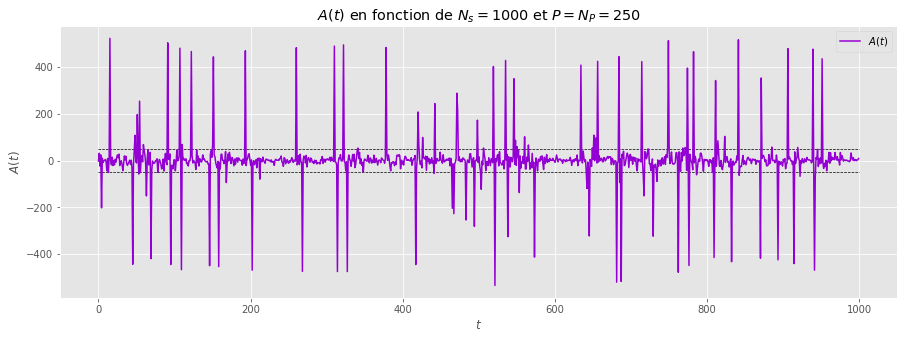

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
game = GC_MinorityGame(fix_seed=True)
game.run()
ax.set(title=f"$A(t)$ en fonction de $N_s={game.Ns}$ et $P=N_P={Np}$", xlabel="$t$", ylabel="$A(t)$")
ax.plot(game.A_tot, label="$A(t)$", color="darkviolet")
ax.hlines(50, 0, game.nb_it, linestyle="--", linewidth=0.7)
ax.hlines(-50, 0, game.nb_it, linestyle="--", linewidth=0.7)
ax.legend();

- Nous voyons :
  - que les fluctuations explosent rapidement.
  - de grande fluctuations de $A(t)$ avec de fortes diminutions, dûes au fait que les agents aprennent, ce qui diminue fortement la prévisibilité, mais suivies de nouveau de fortes fluctuations.

---
# 2 - Rôle des paramètres sur la dynamique

## 1) Paramètres qui produisent de grandes fluctuations de $A(t)$


### $\epsilon$ très petit

- Si $\epsilon$ est très faible, alors la performance minimale pour que l'agent $i$ joue sera faible et cela permettra aux agents d'autant plus rentrer dans le marché. Voici un exemple pour $\epsilon \in \{1,0.01\}$: 

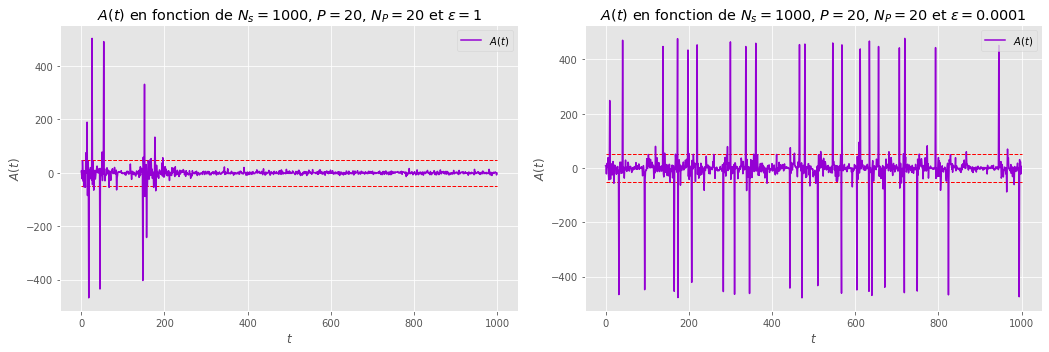

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for i, eps in enumerate([1,0.0001]):
  game = GC_MinorityGame(epsilon=eps, fix_seed=False)
  game.run()
  ax[i].set(title=f"$A(t)$ en fonction de $N_s={game.Ns}$, $P={game.Np}$, $N_P={game.Np}$ et $\epsilon={game.eps}$", xlabel="$t$", ylabel="$A(t)$")
  ax[i].plot(game.A_tot, label="$A(t)$", color="darkviolet")
  ax[i].hlines(50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].hlines(-50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].legend()
plt.tight_layout();

- Nous pouvons faire remarquer que notre cas par défaut étant $\epsilon=0.01$ étant déjà faible, et la performance $U_i$ des agents augmentant en valeur absolues au fil des itérations, augmenter epsilon réduira bien plus la contribution, que le diminuer augmentera les fluctuations.

Voir question 2-4) pour plus de détails. 

### Diminuer $P$, surtout $P < N_S$

- Nous prenons un nombre de producteurs $N_p=250$ ainsi qu'un nombre de spéculateurs $N_S=1000$ fixé, et nous diminuons $P$, on a $P \in \{500, 250, 10 \}$.

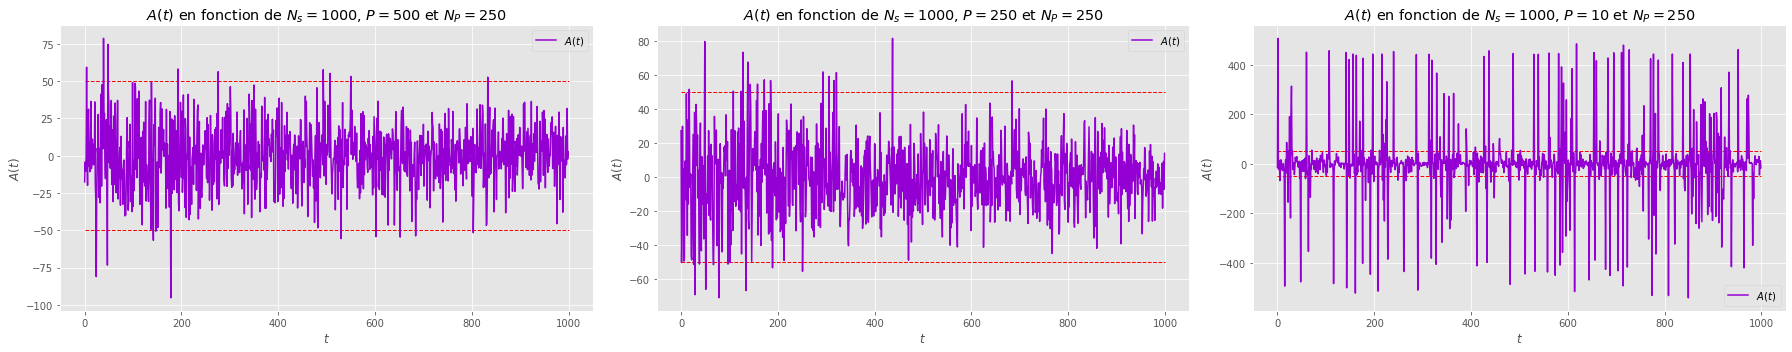

In [ ]:
Ns = 1000
Np = 250
fig, ax = plt.subplots(1,3, figsize=(25,5))
for i, P in enumerate([500, 250, 10]):
  game = GC_MinorityGame(Ns=Ns, P=P, Np=Np, fix_seed=False)
  game.run()
  ax[i].set(title=f"$A(t)$ en fonction de $N_s={game.Ns}$, $P={game.P}$ et $N_P={game.Np}$", xlabel="$t$", ylabel="$A(t)$")
  ax[i].plot(game.A_tot, label="$A(t)$", color="darkviolet")
  ax[i].hlines(50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].hlines(-50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].legend()
plt.tight_layout();

- Nous voyons que : 
   - quand $P$ est deux fois plus grand ou égal au nombre de producteurs, nous n'avons pas vraiment de pics de fluctuations et celles-ci sont plutôt constantes : la prévisibilité apportée est suffisante pour les spéculateurs.
   - Mais, lorsque le nombre d'états $P$ est plus faible, nous voyons une forte augmentation des pics de fluctuations de contributions. 

- Quand $P$ est trop petit, cela signifie qu'il n'y a pas assez d'états de marchés "disponibles" pour avoir vraiment des stratégies exploitables par les agents spéculateurs, ils vont donc avoir moins de prévisibilité disponibles et donc apprendre du bruit.

## 2) Augmentation de $N_p$ 

- Ici nous allons augmenter le nombre de producteurs. Le dernier $N_P$ sera pris de sorte à ce qu'il y ait plus de producteurs que de spéculateurs.
  - Nous avons $N_P \in \{20,500, 1000, 20000\}$

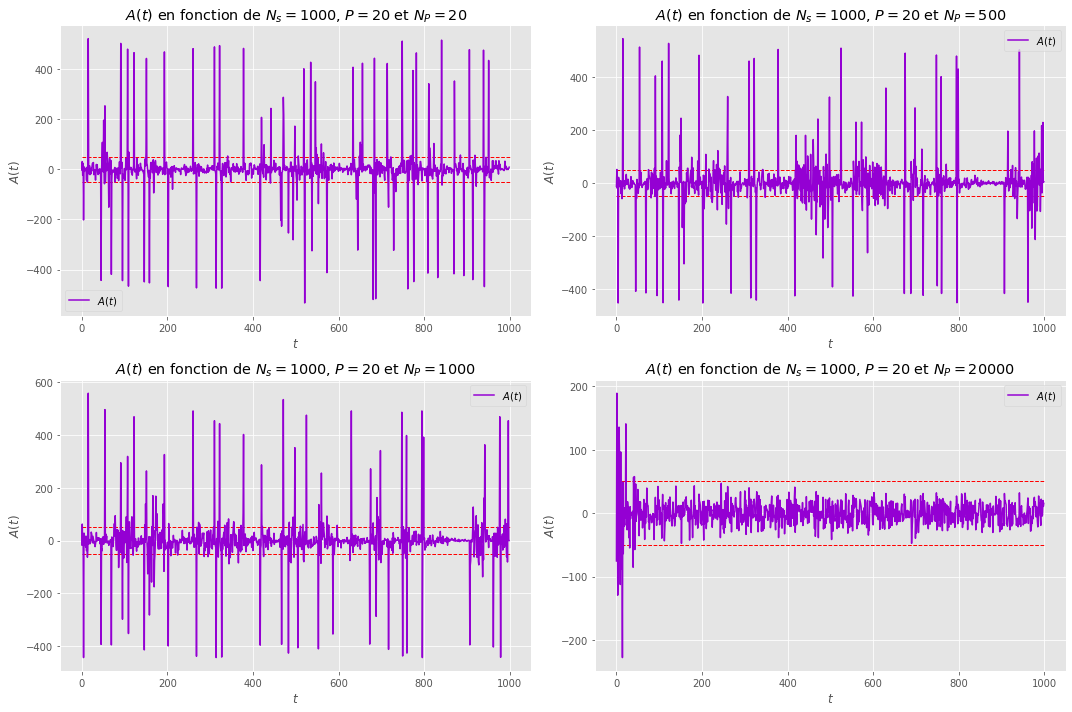

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.ravel()
for i, Np in enumerate([20,500, 1000, 20000]):
  game = GC_MinorityGame(Np=Np, fix_seed=True)
  game.run()
  ax[i].set(title=f"$A(t)$ en fonction de $N_s={game.Ns}$, $P={game.P}$ et $N_P={game.Np}$", xlabel="$t$", ylabel="$A(t)$")
  ax[i].plot(game.A_tot, label="$A(t)$", color="darkviolet")
  ax[i].hlines(50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].hlines(-50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].legend()
plt.tight_layout();

- Dans le premier graphique, on voit que peu producteurs pour trop de spéculateurs cause de grandes fluctuations, car les producteurs apportent trop peu de prévisibilité, les spéculateurs apprennent avec leurs stratégies et la prévisibilité diminue. Comme il n'y en a pas assez, ils apprennent du bruit et cela cause de fortes fluctuations (boucles de rétroaction).

- On voit que lorsque nous augmentons le nombre de producteurs à $20000$, les pics de fluctuations sont absents, cela est du au fait que plus de producteurs est synonyme de plus de prévisibilité apportée. 

- On peut donc dire qu'augmenter le nombre de producteurs stabilise le marché.

- On note que si le nombre d'états de marchés $P$ est grand devant le nombre de spéculateurs $N_s$, le jeu tend vers un jeu aléatoire : il y a trop de possibilité pour les spéculateurs, qui ne peuvent pas apprendre, ils sont submergés d'informations et ne peuvent pas exploiter la prévisibilité.

## 3) Augmentation de $N_S$

Nous avons $N_P=10$ et $\epsilon=0.01$, le premier $N_S$ sera mis de sorte à ce qu'il y ait autant de producteurs que de spéculateurs. \\
Nous avons $N_S \in \{10,100, 1000, 1500\}$

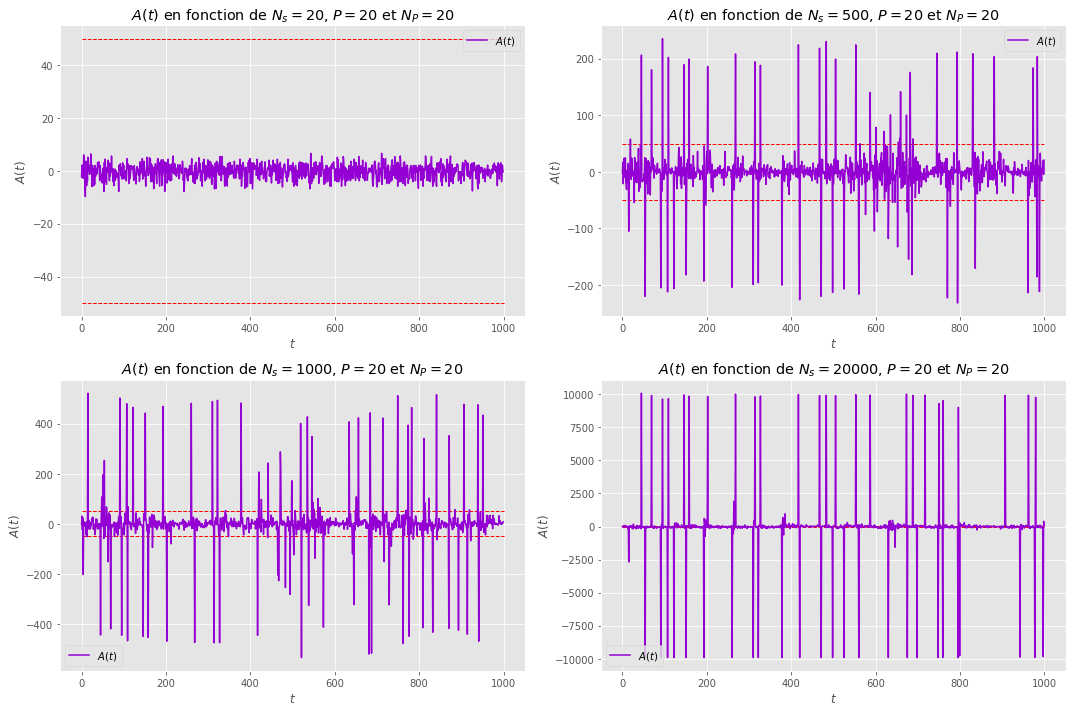

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.ravel()
for i, Ns in enumerate([20,500, 1000, 20000]):
  game = GC_MinorityGame(Ns=Ns, fix_seed=True)
  game.run()
  ax[i].set(title=f"$A(t)$ en fonction de $N_s={game.Ns}$, $P={game.Np}$ et $N_P={game.Np}$", xlabel="$t$", ylabel="$A(t)$")
  ax[i].plot(game.A_tot, label="$A(t)$", color="darkviolet")
  ax[i].hlines(50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].hlines(-50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].legend()
plt.tight_layout()

- Sur le premier graphique, on voit que pour de très faible $N_p = N_S = P = 20$, il y a très peu de fluctuations, car peu de prévisbilité fournie mais peu de spéculateurs pour apprendre du bruit, "tout est calme".

- En revanche, plus on augmente le nombre de spéculateurs, et plus les fluctuations augmentent, on voit même qu'elles explosent si il y a trop de spéculateurs.
  - En fait, si les agents apprennent trop, alors il restera trop de bruit par rapport à la prévisibilité, ils commencent alors à apprendre du bruit car la prévisibilité est trop faible, et amplifient ce bruit : $\textbf{boucles de rétroaction}$.

- On peut donc dire qu'augmenter le nombre de spéculateurs déstabilise le marché.

- On note : c'est intéressant de remarquer la proportionnalité de l'amplitude des fluctuations en fonction du nombre de spéculateurs : pour $500$ spéculateurs, les amplitudes maximales sont un peu plus grandes que $200$, un peu plus grandes que $400$ pour $N_s = 1000$, et que $8000-10000$ pour $N_s = 20000$.

## 4) Varier $\epsilon$

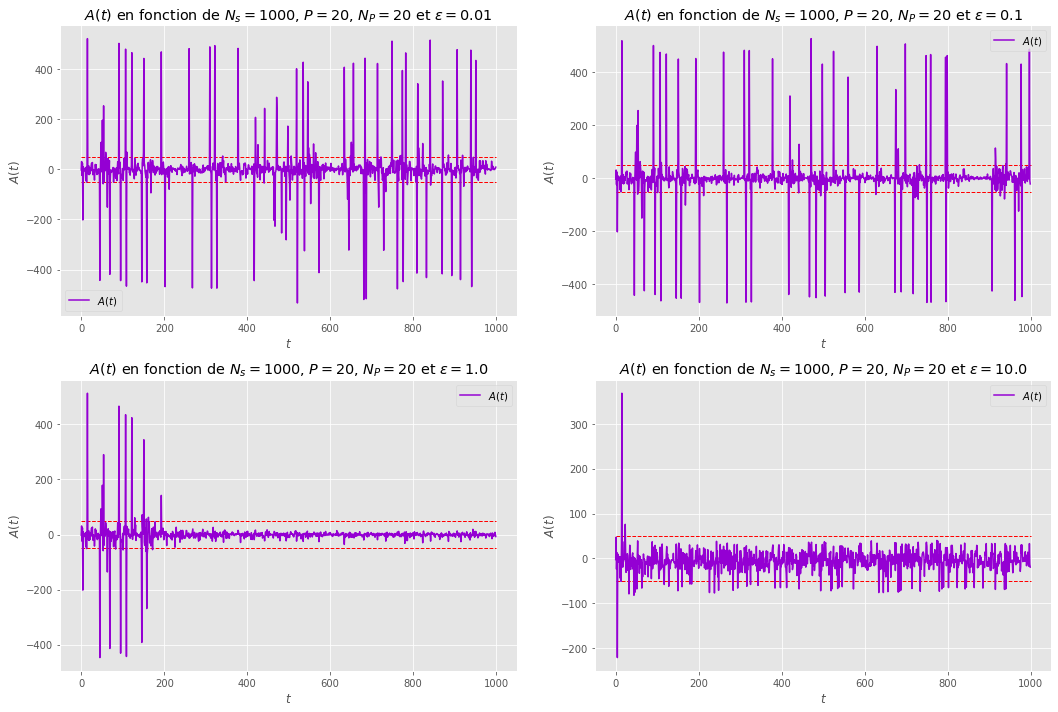

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.ravel()
for i, eps in enumerate(np.logspace(-2,1,4)):
  game = GC_MinorityGame(epsilon=eps, fix_seed=True)
  game.run()
  ax[i].set(title=f"$A(t)$ en fonction de $N_s={game.Ns}$, $P={game.Np}$, $N_P={game.Np}$ et $\epsilon={game.eps}$", xlabel="$t$", ylabel="$A(t)$")
  ax[i].plot(game.A_tot, label="$A(t)$", color="darkviolet")
  ax[i].hlines(50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].hlines(-50, 0, game.nb_it, linestyle="--", linewidth=1, color="red")
  ax[i].legend()
plt.tight_layout()

- Nous voyons donc que plus $\epsilon$ augmente, et plus les fluctuations diminuent d'un point de vue général. Mais surtout, pour $\epsilon=1$ par exemple, au bout de quelques itérations, il n'y a plus du tout de contributions. Cela provient du fait que la performance minimale requise afin de rentrer sur le marché pour les spéculateurs est trop grande, et plus aucun ne joue après un certain temps, leur stratégie n'était pas assez bonnes.

- On voit que pour un epsilon de $10$, la contribution est seulement celle dû à celle des producteurs, plus aucun spéculateurs ne jouent car verrait sa performance $U_i$ négative à chaque itération.

- $\epsilon$ peut être vu comme la performance minimale pour qu'un agent utilise une stratégie. Il peut également être interprété comme la représentation des coûts de transaction.

- On peut donc dire que : 
  - trop diminuer $\epsilon$ destabilisera le marché car trop d'agents vont pouvoir jouer, et cela augmentera le bruit. 
  - en revanche, trop l'augmenter revient à n'avoir presque aucun spéculateur dans notre jeu.

---
# 3 - Dynamique de la prévisibilité

## 1) Evolution de $\sigma^{2}$ et $H$ et conditions pour que les fluctuations explosent

- On garde nos paramètres par défaut car les fluctuations explosent avec, on les rappelle ici : 
  - $1000$ itérations
  - $N_s = 1000$ spéculateurs
  - $P = 20$ états de marché
  - $N_p = 20$ produteurs 
  - $epsilon = 0.01$ 

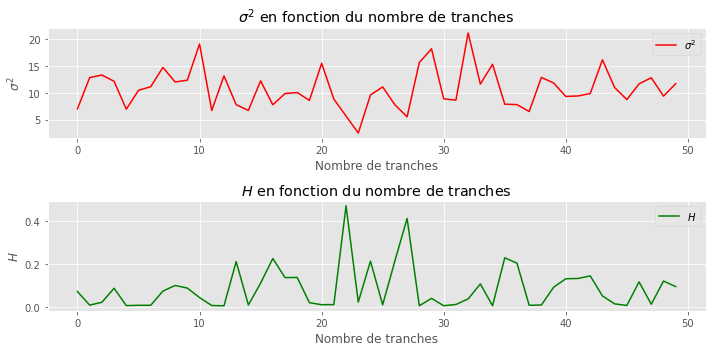

In [ ]:
game = GC_MinorityGame(nb_it=10000, fix_seed=False)
game.run()
game.compute_sig_H()
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax.ravel()
ax[0].set(title="$\sigma^{2}$ en fonction du nombre de tranches", ylabel="$\sigma^{2}$", xlabel="Nombre de tranches")
ax[0].plot(game.sigma2, label="$\sigma^{2}$", color="red")
ax[1].plot(game.H, label="$H$", color="green")
ax[1].set(title="$H$ en fonction du nombre de tranches", ylabel="$H$", xlabel="Nombre de tranches")
ax[0].legend()
ax[1].legend()
plt.tight_layout()

- On voit donc que la condition pour que les fluctuations explosent et qu'il n'y ait plus de prévisibilité. En effet, on voit que les pics de fluctuations sont pour des $H$ proches de $0$, et vice-versa. 

- L'absence de prévisibilité signifie que les spéculateurs ont "mangés" toute la prévisibilité, qui peut se caractériser comme de la nourriture dans un système biologique par exemple.

- On note quand même que la part d'aléatoires ne nous permet bien d'observer parfaitement le principe.

### On trace $\sigma^{2}$ et $H$ en fonction de $N_S \in [10,500]$ avec $P=N_P=20$

- Ici on moyenne pour $100$ réalisations, et on moyenne également sur les tranches.

In [ ]:
data = pd.DataFrame(columns=["Ns", "sigma2", "H"])
P = 20
for Ns in tqdm(np.linspace(10,200, 15)):
  for i in range(100):
    game = GC_MinorityGame(Ns=int(Ns))
    game.run()
    game.compute_sig_H()
    data = pd.concat([data, pd.DataFrame(np.array([np.array([Ns]*len(game.sigma2)), game.sigma2, game.H]).transpose(), columns=["Ns", "sigma2", "H"])])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in true_divide


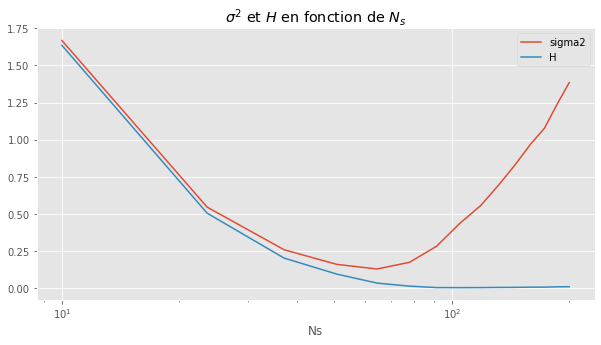

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
data.groupby("Ns").mean().plot(ax=ax)
ax.set(title="$\sigma^{2}$ et $H$ en fonction de $N_{s}$")
plt.xscale("log")

- Nous pouvons ainsi voir que les fluctuations explosent quand $H$ tend vers $0$.

## 2) Après l'état stationnaire $200P/\epsilon$

### On trace $\sigma^{2}/P$ et $H/P$ en fonction de $n_S = N_S/P$ avec $P=N_P=10$

In [ ]:
data = pd.DataFrame(columns=["Ns", "sigma2", "H"])
P = 10
for Ns in tqdm(np.linspace(10,1500, 10)):
  for i in range(10):
    game = GC_MinorityGame(Ns=int(Ns), P=P, Np=P, wait_stationnarity=True)
    game.run()
    game.compute_sig_H(after_station=True)
    data = pd.concat([data, pd.DataFrame(np.array([Ns/P, game.sigma2/P, game.H/P]).reshape(1,-1), columns=["Ns", "sigma2", "H"])])

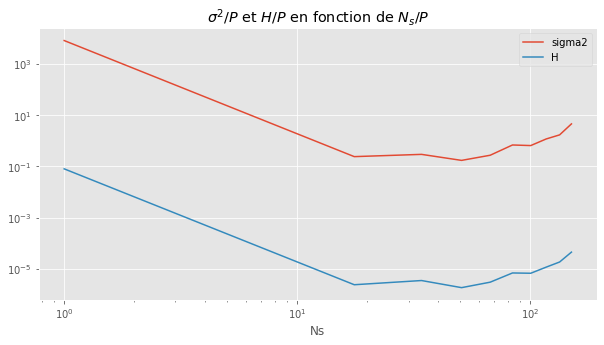

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
data.groupby("Ns").mean().plot(ax=ax)
ax.set(title="$\sigma^{2}/P$ et $H/P$ en fonction de $N_{s}/P$")
plt.xscale("log")
plt.yscale("log")

- Nous voyons que la prévisibilité et $\sigma^{2}$ ont la même dynamique, tendent vers 0 lorsque le nombre de spéculateurs augmentent. 

- Cependant, le fait que la prévisibilité remonte également comme les fluctuations est assez surprenant.

### Comparaison de $H_0$ et $2\epsilon \mathbb{E}[N_{active}]$

- Nous allons vérifier que $H_0 = 0$ n'est pas possible quand $\epsilon > 0$ 

  - Si on a $\epsilon > 0$, alors il y aura toujours des spéculateurs qui ne joueront pas dans notre jeu. Cela signifie que la prévisibilité ne pourrait jamais être totalement épuisée et qu'il en restera toujours une infime partie.   
  - En effet, si $\epsilon=0$, alors tous lse spéculateurs joueront dans tous les cas et la prévisibilité pourra atteindre $0$.

- On prend $N_P = P = 10$

#### Avec $\epsilon > 0$

In [ ]:
Nss = np.linspace(10,1500, 10).astype("int")
esp_N_actif = np.zeros((len(Nss), 10))
Ho = np.zeros((len(Nss), 10))
P = 10
i = 0
for Ns in tqdm(Nss):
  for j in range(10):
    game = GC_MinorityGame(Ns=int(Ns), P=P, Np=P, wait_stationnarity=True)
    game.run()
    game.compute_sig_H(after_station=True)
    esp_N_actif[i,j] = sum(game.nb_ag_actifs[game.station_point:])/game.nb_it
    Ho[i,j] = game.H
  i += 1

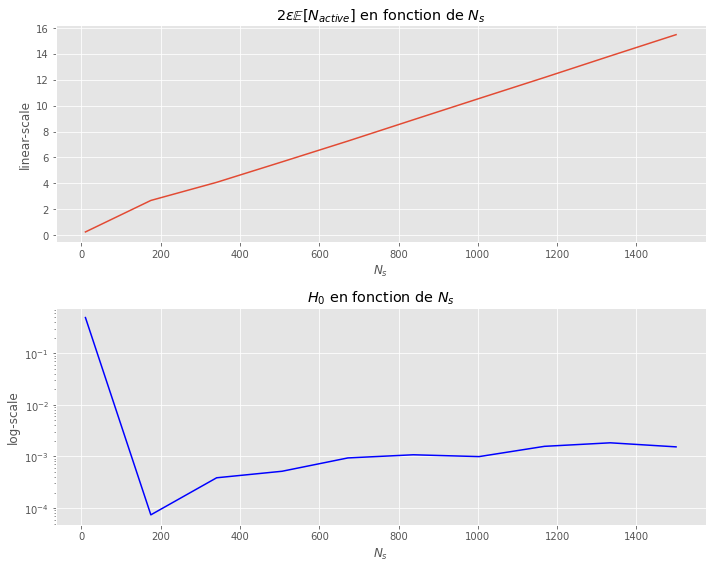

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax.ravel()
ax[0].set(title="$2\epsilon\mathbb{E}[N_{active}]$ en fonction de $N_s$", xlabel="$N_s$", ylabel="linear-scale")
ax[1].set(title="$H_0$ en fonction de $N_s$", xlabel="$N_s$", ylabel="log-scale", yscale="log")
ax[1].plot(Nss, np.mean(Ho, axis=1), label="$H_0$", c="b")
ax[0].plot(Nss, np.mean(2*game.eps*esp_N_actif, axis=1), label="$2\epsilon\mathbb{E}[N_{active}]$")
plt.tight_layout()

- Ainsi on voit que le nombre d'agents actifs augmente moins vite que le nombre de spéculateurs. 

- Et que la prévisibilité est proche de $0$ mais augmente après $N_s = 200$

---
---
# <center> TP 3.3 - Gains et impacts de marché <center/>

> Dans cette partie nous allons étudier les gains des différents investisseurs, étudier la différence entre gain espéré et réalisé, et également l'impact d'un seul investisseur sur la dynamique de marché.

# 1 - Gains de catégories d'investisseurs

- Nous avons ajouté à la classe les différents gains des spéculateurs et producteurs : 

  - $G_{spec}(t) = - A_{spec}(t)A_{tot}(t)$

  - $G_{prod}(t) = - \Omega_{\mu(t)}A_{tot}(t)$

- Ainsi que les gains moyens (average payoff) : 

  - $\mathbb{E}[G_{spec}] = \frac{1}{P}\underset{\mu}{\sum}\mathbb{E}[-A_{spec}A_{tot} | \mu]$

  - $\mathbb{E}[G_{prod}] = \frac{1}{P}\underset{\mu}{\sum}\mathbb{E}[-\Omega A_{tot} | \mu]$

## 1) Gain moyen des producteurs et des spéculateurs en fonction de $N_s$

In [ ]:
# Paramètres a changer par la suite
Ns = 1000
Np = 1000
P = 10
eps = 0.01
nb_it = 1000
seed = 100

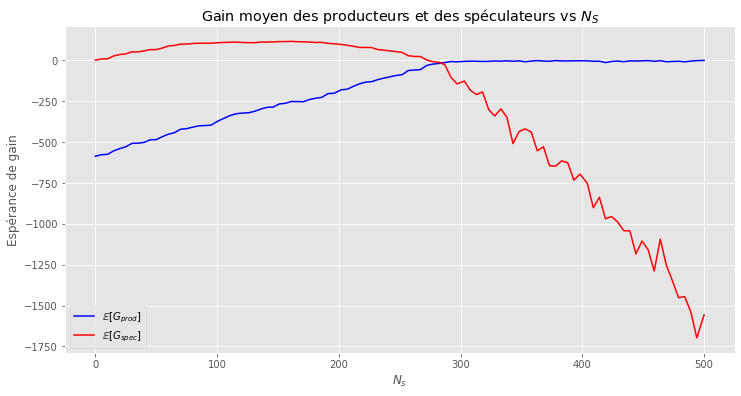

In [ ]:
Nss = np.linspace(0,500,100).astype("int")

avgGprods = np.zeros(len(Nss))
avgGspecs = np.zeros(len(Nss))
for i in range(len(Nss)):
  test = GC_MinorityGame(nb_it=nb_it, Ns = Nss[i], P=20, Np=1000, epsilon=0.01, fix_seed=True, compute_gains=True)
  test.run()
  avgGprods[i] = test.avg_payoff_prod
  avgGspecs[i] = test.avg_payoff_spec

fig, ax = plt.subplots(figsize=(12,6))
sns.despine()
ax.set(title="Gain moyen des producteurs et des spéculateurs vs $N_S$", xlabel="$N_s$", ylabel="Espérance de gain")
ax.plot(Nss, avgGprods, color="b", label=r"$\mathbb{E}[G_{prod}]$")
ax.plot(Nss, avgGspecs, color="r", label=r"$\mathbb{E}[G_{spec}]$")
ax.legend()

- Sans les spéculateurs, on a $$\mathbb{E}[G_{prod}] = -\Omega^{2} < 0$$

- On voit donc que jusqu'à 300 spéculateurs environ, leur gain moyen est positif, ils apprenent des producteurs. Le gains moyen des producteurs est quant à lui négatif. Mais plus le nombre de spéculateurs augmente et plus leur gain diminue, cela est du à la diminution de la prévisibilité et à l'augmentation des fluctuations vu précedemment.

- Quand il n'y a plus de prévisibilité, le gain moyen des producteurs est nul.

- Plus le nombre de producteurs est grand pour un même nombre d'états, et plus les spéculateurs gagnent de l'argent grâce aux producteurs, il faudra plus de spéculateurs pour diminuer la prévisibilité jusqu'à ce que leur gain soit en moyenne négatif.

## 2) Gain moyen des producteurs et des spéculateurs en fonction de $N_P$

On prend $N_p = P = 10$ pour avoir des gains moyens de spéculateurs $\leq 0$ et strictement dès que $N_s > 50$.

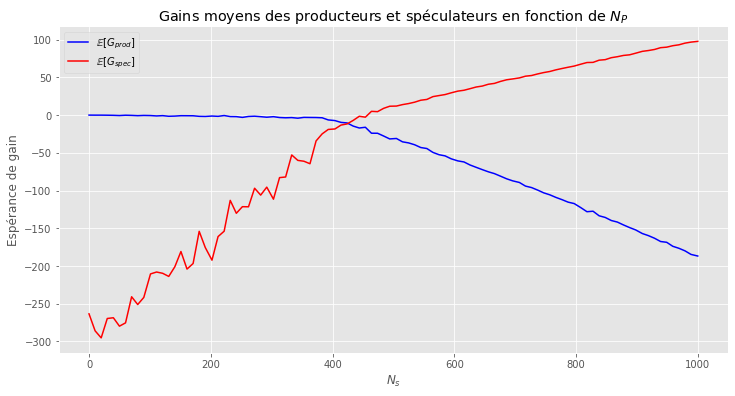

In [ ]:
Nps = np.linspace(0,1000,100).astype("int")

avgGprods = np.zeros(len(Nss))
avgGspecs = np.zeros(len(Nss))
for i in range(len(Nss)):
  test = GC_MinorityGame(nb_it=nb_it, Ns = 200, P=20, Np=Nps[i], epsilon=0.01, fix_seed=True, compute_gains=True)
  test.run()
  avgGprods[i] = test.avg_payoff_prod
  avgGspecs[i] = test.avg_payoff_spec

fig, ax = plt.subplots(figsize=(12,6))
sns.despine()
ax.set(title="Gains moyens des producteurs et spéculateurs en fonction de $N_P$", xlabel="$N_s$", ylabel="Espérance de gain")
ax.plot(Nps, avgGprods, color="b", label=r"$\mathbb{E}[G_{prod}]$")
ax.plot(Nps, avgGspecs, color="r", label=r"$\mathbb{E}[G_{spec}]$")
ax.legend()

- Le graphe paraît cohérent avec le précédent : 

  - Avant $N_P = 200$, il y a trop de spéculateurs et pas assez de producteurs, donc les spéculateurs ne peuvent pas gagner d'argent. 

  - En revanche, après $N_P=200$, le nombre de producteurs est suffisant pour que les spéculateurs puissent apprendre et gagner de l'argent. 

  - Plus il y a de producteurs, et plus les spéculateurs (au nombre de $200$) peuvent gagner de l'argent.


## 3) Décrire la relation entre producteurs et spéculateurs (d'un point de vue écologie de populations)

- Il est indéniable que sans les producteurs, les spéculateurs ne peuvent pas gagner d'argent. Si les producteurs ne sont pas assez comparé aux spéculateurs, ceux-ci sont trop nombreux et les gains moyens ne peuvent pas être positifs : leur comportement modifie trop le système et ils perdent de l'argent en général.

- Quand il ne reste presque plus de prévisibilité (la prévisibilité diminue car les spéculateurs sont capables d'apprendre), les spéculateurs ont un trop gros impact, ce qui cause des explosions de volatilité : boucles de rétroactions.

---
# 2 - Gain réel, gain espéré

- Nous prenons les paramètres suivant afin que le gain n'explose pas :

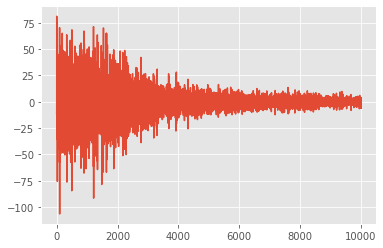

In [ ]:
test = GC_MinorityGame(nb_it=10000, Ns=200, Np=200, P=10, epsilon=0.01, fix_seed=False, compute_gains=True)
test.run()
plt.plot(test.A_tot)

## 1) Calculer $\mathbb{E}[A_{total}|\mu $

- Les moyennes conditionnelles sont calculées dans la classe.

## 2) Ajoute de l'agent best

- On va ajouter un agent qui a tout compris au jeu. 

- Il jouera $a_{best}(\mu) = -sign(\mathbb{E}[A_{tot}|\mu])$

- Son espérance de gain naîve est : $$\mathbb{E}[G_{best}^{naïve}] = \frac{1}{P}\underset{\mu}{\sum}\left|\mathbb{E}[A_{tot}|\mu]\right| \approx H_0$$



In [ ]:
a_best = np.sign(test.avg_A_cond_tot)
avg_payoffnaive_best = (np.sum(np.abs(test.avg_A_cond_tot)))/P
print(f"L'espérance de gain naïve de l'agent est de : {np.round(avg_payoffnaive_best, 5)}")

L'espérance de gain naïve de l'agent est de : 0.02934


## 3) Calul du gain moyen de $a_{best}$, comparaison avec son gain estimé
- En réalité, voici le gain de l'agent $\textit{best}$ : 

$$\mathbb{E}[G_{best}^{real}] = - \frac{1}{P}\underset{\mu}{\sum}a_{\mu}^{best}\mathbb{E}[A_{tot} + a_{\mu}^{best}|\mu] \approx H_0 - 1$$

- Donc, si $H_0 < 1$, l'agent $\textit{best}$ va perdre de l'argent.

- D'une manière plus générale, voici le gain d'un agent $i$ dans ce jeu : 

$$G_i(t) = -a_{i}(t)n_{i}(t)A_{tot}(t) = -a_{i}(i)A_{tot}^{-i}(t) - a_{i}^{2}(t)n_{i}^{2}(t) = -a_{i}(i)A_{tot}^{-i}(t) - 1$$

  - Avec $-a_{i}(i)A_{tot}^{-i}(t)$ le gain virtuel, on voit donc que si l'agent joue, son impact est de $-1$, et ainsi, si le gain virtuel est inférieur à $1$, alors il perdra de l'argent. 

- Nous allons effectuer le jeu $100$ fois, et moyenner la différence entre gain réel et gain naïf de l'agent, pour ces paramètres : 

In [ ]:
diff = np.zeros(100)
for i in tqdm(range(100)):
  test = GC_MinorityGame(nb_it=20000, Ns=200, Np=200, P=10, epsilon=0.01, it_a_best=10000, fix_seed=False, compute_gains=True)
  test.run()
  diff[i] = test.realgain_best - test.naivegain_best
print(f"La moyenne sur 100 jeux de la différence entre gains naïf et réel de l'agent best est : {np.average(diff)}")


La moyenne sur 100 jeux de la différence entre gains naïf et réel de l'agent best est : -1.0085331402861397


- Nous voyons donc bien (avec ces paramètres), que le terme d'impact de l'agent réduit son gain ! 

- Nous retrouvons bien le $-1$ en moyenne.